In [80]:
from sonnet_processing import read_sonnet_file, preprocess_sonnet, get_sonnet_phoneme_dict, get_cmu_simvecs_embedding, create_cmu_mean_simvecs_embedding_df, create_phoneme_embedding_df

import cmudict
import re
from collections import Counter
import pandas as pd
import numpy as np
import json

In [81]:
sonnets_list = []
curr_sonnet_idx = 0
sonnets_list, curr_sonnet_idx = read_sonnet_file("text/sonnets.txt", "Shakespeare", sonnets_list, curr_sonnet_idx) #154
sonnets_list, curr_sonnet_idx = read_sonnet_file("text/spenser_sonnets.txt", "Spenser", sonnets_list, curr_sonnet_idx) #89
sonnets_list, curr_sonnet_idx = read_sonnet_file("text/sidney_sonnets.txt", "Sidney", sonnets_list, curr_sonnet_idx) #108
sonnets_dict = {idx: sonnet for idx, sonnet in enumerate(sonnets_list)}

In [82]:
# export sonnet text as json
import json
# sonnets_json = json.dumps(sonnets_list)
# with open('sonnets_shakespeare_spenser_sidney.json', 'w') as outfile:
#     json.dump(sonnets_json, outfile)
with open('sonnets_shakespeare_spenser_sidney.json', 'w') as outfile:
     json.dump(sonnets_list, outfile)

In [83]:
preprocessed_sonnets_list =[preprocess_sonnet(sonnet["text"]) for sonnet in sonnets_list]

In [84]:
with_lexical_stress = False
df_counts, normalized_phoneme_count_mtx, all_words_not_in_dict = create_phoneme_embedding_df(preprocessed_sonnets_list, with_lexical_stress)
print(Counter(all_words_not_in_dict).most_common(25))
df_counts.head()

[('beauteous', 9), ('canst', 9), ("stol'n", 9), ("virtue's", 9), ('vouchsafe', 8), ('sprites', 8), ("cupid's", 8), ("ev'n", 8), ('shouldst', 7), ('plaints', 7), ("lov'st", 6), ('gainst', 6), ('wouldst', 6), ('tempests', 6), ('whereto', 6), ('sith', 6), ('deathe', 5), ('methinks', 5), ("soul's", 4), ('basest', 4), ("know'st", 4), ('wherewith', 4), ('twixt', 4), ('ravished', 4), ('therewith', 4)]


,AH,EY,AE,ER,T,JH,OY,ZH,G,V,...,HH,CH,AW,AA,S,TH,Y,NG,K,UW
0,0.002971,0.001616,0.002154,0.003320,0.003164,0.000000,0.0,0.000000,0.002070,0.000736,...,0.001289,0.001022,0.002863,0.001555,0.002401,0.000000,0.001838,0.001765,0.002599,0.003248
1,0.001943,0.003231,0.002154,0.003320,0.001964,0.002179,0.0,0.017241,0.002070,0.002209,...,0.001289,0.003067,0.007634,0.001037,0.002701,0.000926,0.005515,0.003530,0.002971,0.003609
2,0.003428,0.002019,0.001795,0.002213,0.001964,0.006536,0.0,0.000000,0.005176,0.002946,...,0.003007,0.000000,0.007634,0.004147,0.002551,0.000926,0.000000,0.001765,0.001485,0.002887
3,0.002400,0.001616,0.001436,0.001475,0.002509,0.002179,0.0,0.000000,0.008282,0.003682,...,0.000859,0.004090,0.005725,0.004147,0.003151,0.001852,0.007353,0.003530,0.002228,0.003609
4,0.003200,0.002423,0.001436,0.005164,0.003709,0.002179,0.0,0.000000,0.003106,0.002946,...,0.000859,0.002045,0.002863,0.001555,0.003151,0.001852,0.002757,0.000883,0.002599,0.001804


In [85]:
df_embeddings, cmu_embeddings_as_mtx, all_words_not_in_dict = create_cmu_mean_simvecs_embedding_df(preprocessed_sonnets_list)
print(Counter(all_words_not_in_dict).most_common(25))

[('beauteous', 9), ('canst', 9), ("stol'n", 9), ("virtue's", 9), ('vouchsafe', 8), ('sprites', 8), ("cupid's", 8), ("ev'n", 8), ('shouldst', 7), ('plaints', 7), ("lov'st", 6), ('gainst', 6), ('wouldst', 6), ('tempests', 6), ('whereto', 6), ('sith', 6), ('deathe', 5), ('methinks', 5), ('descry', 5), ('wherefore', 4), ("soul's", 4), ('basest', 4), ("know'st", 4), ('wherewith', 4), ('twixt', 4)]


In [86]:
# create distance matrix using cosine distance
from sklearn.metrics.pairwise import cosine_distances
cosine_dists = cosine_distances(normalized_phoneme_count_mtx)
print(cosine_dists.shape)
cosine_dists_as_lists = cosine_dists.tolist()

#print(cosine_dists)

(351, 351)


In [87]:
# save cosine dist matrix
with open("sonnet_dists_shakespeare_spenser_sidney.json", "w") as f:
    json.dump(cosine_dists_as_lists, f)

In [88]:
vector = "counts" # or "embedding"

if vector == "counts":
    df = df_counts
    filename_out_pca = 'pca_counts_sonnets_position_shakespeare_spenser_sidney.json'
    filename_out_lda = 'lda_counts_sonnets_position_shakespeare_spenser_sidney.json'
elif vector == "embedding":
    df = df_embeddings
    filename_out_pca = 'pca_embedding_sonnets_position_shakespeare_spenser_sidney.json'
    filename_out_lda = 'lda_embedding_sonnets_position_shakespeare_spenser_sidney.json'
    

In [89]:
# encode author as shakespeare (1) or not (0)
df['Author'] = 1
df.loc[154:, "Author"] = 0

In [90]:
df.shape

(351, 40)

In [91]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

X = df.iloc[:,:-1]
y = df['Author']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
scaler = StandardScaler().fit(X_train) #For classification, fit scaler only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Use all datapoints
X = StandardScaler().fit_transform(X)
clf = LinearDiscriminantAnalysis()
clf.fit(X, y)

              precision    recall  f1-score   support

           0       0.66      0.85      0.74        34
           1       0.81      0.59      0.69        37

    accuracy                           0.72        71
   macro avg       0.74      0.72      0.72        71
weighted avg       0.74      0.72      0.71        71



LinearDiscriminantAnalysis()

In [92]:
feat = pd.Series(clf.coef_[0], index=df.columns[0:-1], name='coef')

In [93]:
feat.sort_values()[0:12]

L    -0.689944
OY   -0.508733
S    -0.489003
HH   -0.409625
CH   -0.404300
EY   -0.284720
G    -0.224471
B    -0.205891
R    -0.203822
SH   -0.157242
W    -0.140081
TH   -0.139476
Name: coef, dtype: float64

In [69]:
(feat.sort_values(ascending=True)[-12:-1]).sort_values(ascending=False)

DH    0.597622
AH    0.544485
IH    0.436748
Y     0.433899
AE    0.410804
OW    0.345654
JH    0.341124
NG    0.323798
AY    0.296485
AO    0.249573
EH    0.243388
Name: coef, dtype: float64

In [70]:
# Inspect "most" and "least" shakespeare-sounding poems
sonnets_embedded_1d = clf.transform(X)
print(np.argmax(sonnets_embedded_1d))
print(np.argmin(sonnets_embedded_1d))

print(sonnets_list[np.argmax(sonnets_embedded_1d)]['text'])
print(sonnets_list[np.argmin(sonnets_embedded_1d)]['text'])

164
68
Daily when I do seek and sew for peace,
And hostages do offer for my truth:
She cruel warrior doth herself address
To battle, and the weary war renew'th.
Nor will be moved with reason or with ruth,
To grant small respite to my restless toil:
But greedily her fell intent persueth,
Of my poor life to make unpityed spoil.
Yet my poor life, all sorrows to assoyle,
I would her yield, her wrath to pacify:
But then she seeks with torment and turmoil,
To force me live, and will not let me die.
All pain hath end and every war hath peace,
But mine no price nor prayer may surcease.

  Those parts of thee that the world's eye doth view
  Want nothing that the thought of hearts can mend;
  All tongues--the voice of souls--give thee that due,
  Uttering bare truth, even so as foes commend.
  Thy outward thus with outward praise is crown'd;
  But those same tongues, that give thee so thine own,
  In other accents do this praise confound
  By seeing farther than the eye hath shown.
  They look 

In [71]:
# sonnets_embedded_1d

In [ ]:
# print("phonene", "shkspr", "other")
# for ph,i, j in zip(phoneme_names_trimmed, phoneme_count_mtx[np.argmax(sonnets_embedded_1d),:] ,phoneme_count_mtx[np.argmin(sonnets_embedded_1d),:]):
#     if not (round(i) ==0 and round(j)==0):
#         print(ph, round(i), round(j))


In [72]:
df['Author'] = 1
df.loc[154:,'Author'] = 0
df.loc[243:,'Author'] = 2

In [74]:
X = df.iloc[:,:-1]
y = df['Author']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2 )
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
clf = LinearDiscriminantAnalysis(n_components=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Spenser, Shakespeare, Sidney")
print(confusion_matrix(y_test,y_pred))

X = StandardScaler().fit_transform(X)
clf.fit(X, y)

              precision    recall  f1-score   support

           0       0.80      0.47      0.59        17
           1       0.65      0.81      0.72        32
           2       0.71      0.68      0.70        22

    accuracy                           0.69        71
   macro avg       0.72      0.65      0.67        71
weighted avg       0.71      0.69      0.68        71

Spenser, Shakespeare, Sidney
[[ 8  7  2]
 [ 2 26  4]
 [ 0  7 15]]


LinearDiscriminantAnalysis(n_components=2)

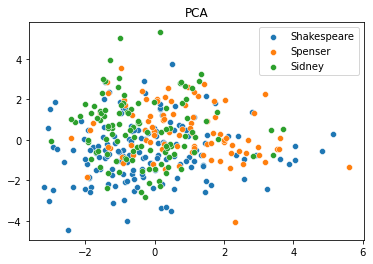

In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt

X = StandardScaler().fit_transform(X)
pca =  PCA(n_components=2).fit(X)
sonnets_embedded_pca = pca.transform(X)
sns.scatterplot(x = sonnets_embedded_pca[0:154,0],y=sonnets_embedded_pca[0:154,1], label="Shakespeare")
sns.scatterplot(x=sonnets_embedded_pca[154:243,0],y=sonnets_embedded_pca[154:243,1], label="Spenser")
sns.scatterplot(x=sonnets_embedded_pca[243:,0],y=sonnets_embedded_pca[243:,1],label="Sidney")
plt.title('PCA')
plt.show()

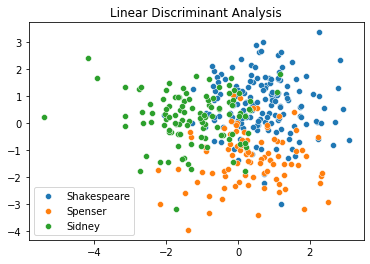

In [75]:
sonnets_embedded = clf.transform(X)
sns.scatterplot(x = sonnets_embedded[0:154,0],y=sonnets_embedded[0:154,1], label="Shakespeare")
sns.scatterplot(x=sonnets_embedded[154:243,0],y=sonnets_embedded[154:243,1], label="Spenser")
sns.scatterplot(x=sonnets_embedded[243:,0],y=sonnets_embedded[243:,1],label="Sidney")
plt.title('Linear Discriminant Analysis')
plt.show()

In [76]:
sonnet_positions = []
for idx, embedded_sonnet in enumerate(sonnets_embedded):
    s = {"sonnet_id": idx, "x":  embedded_sonnet[0], "y": embedded_sonnet[1], "author":sonnets_list[idx]["author"]}
    sonnet_positions.append(s)

In [77]:
with open(filename_out_lda, 'w') as outfile:
    json.dump(sonnet_positions, outfile)

In [78]:
sonnet_positions_pca = []
for idx, embedded_sonnet in enumerate(sonnets_embedded_pca):
    s = {"sonnet_id": idx, "x":  embedded_sonnet[0], "y": embedded_sonnet[1], "author": sonnets_list[idx]["author"]}
    sonnet_positions_pca.append(s)

In [79]:
with open(filename_out_pca, 'w') as outfile:
    json.dump(sonnet_positions_pca, outfile)